In [1]:

import glob
import uproot as up
import awkward as ak
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm as tqdm
import multiprocessing as mp
import functools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


In [2]:
def old_decay(file):
    
    tfile= up.open(file)
    events=tfile["Events"]
    area=events["pulsesODHG.pulseArea_phd"]
    area=area.array()
    area=ak.flatten(area)
    
    coincidence=events["pulsesODHG.coincidence"]
    coincidence=coincidence.array()
    coincidence=ak.flatten(coincidence)
    
    peak_time=events["pulsesODHG.peakTime_ns"]
    peak_time=peak_time.array()
    peak_time=ak.flatten(peak_time)   

    peak_amp=events["pulsesODHG.peakAmp"]
    peak_amp=peak_amp.array()
    peak_amp=ak.flatten(peak_amp)
    
    t_25=events["pulsesODHG.areaFractionTime25_ns"]
    t_25=t_25.array()
    t_25=ak.flatten(t_25)
    
    t_50=events["pulsesODHG.areaFractionTime50_ns"]
    t_50=t_50.array()
    t_50=ak.flatten(t_50)
    
    t_75=events["pulsesODHG.areaFractionTime75_ns"]
    t_75=t_75.array()
    t_75=ak.flatten(t_75)
    
    start=events["pulsesODHG.pulseStartTime_ns"]
    start=start.array()
    start=ak.flatten(start)
    
    end=events["pulsesODHG.pulseEndTime_ns"]
    end=end.array()
    end=ak.flatten(end)
    
    length=end-start
    area_time=t_75/area
    
    return [area,coincidence,peak_time,peak_amp,t_25,t_50,t_75,length,area_time]

In [3]:
def data_decay(file):
    
    tfile= up.open(file)
    events=tfile["Events"]
    
    area=np.array(events["pulsesODHG.pulseArea_phd"])
    area=area.flatten()
    
    truth = tfile['RQMCTruth']
    pp = np.array(truth['mcTruthEvent./mcTruthEvent.parentParticle'])
    pp=pp.flatten()
    
    coincidence=np.array(events["pulsesODHG.coincidence"])
    coincidence=coincidence.flatten()
    
    
    peak_time=np.array(events["pulsesODHG.peakTime_ns"])
    peak_time=peak_time.flatten()
       

    peak_amp=np.array(events["pulsesODHG.peakAmp"])
    peak_amp=peak_amp.flatten()
    
    
    t_25=np.array(events["pulsesODHG.areaFractionTime25_ns"])
    t_25=t_25.flatten()
    
    
    t_50=np.array(events["pulsesODHG.areaFractionTime50_ns"])
    t_50=t_50.flatten()
    
    
    t_75=np.array(events["pulsesODHG.areaFractionTime75_ns"])
    t_75=t_75.flatten()
    
    
    start=np.array(events["pulsesODHG.pulseStartTime_ns"])
    start=start.flatten()
    
    
    end=np.array(events["pulsesODHG.pulseEndTime_ns"])
    end=end.flatten()
    
    
    length=end-start
    area_time=t_75/area
    
    return [area,coincidence,peak_time,peak_amp,t_25,t_50,t_75,length,area_time,pp]


In [4]:
def data():
    columns={'Pulse Area' : [], 'Coincidence' : [], 'Peak Time' : [],'Peak Amp' : [], 
             '25% time' : [], '50% time' : [],'75% time' : [], 'Pulse Time' : [], 'time/area' : [],'tag' : []}
    columns_exp=['Pulse Area','Coincidence','Peak Time','Peak Amp','25% time',
             '50% time', '75% time', 'Pulse Time', 'time/area']
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_internals/lzap_output/*')
    with mp.Pool(60) as pool:
            internals_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=3000))
    internals_data=pd.DataFrame(np.concatenate(internals_data,axis=1).T.tolist(),columns=columns)
    internals_data=(((internals_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    internals_data=internals_data[(internals_data["Pulse Area"] > 5)&(internals_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/gdls_neutrons/lzap_output/*')
    with mp.Pool(60) as pool:
            neutron_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=1962))
    neutron_data=pd.DataFrame(np.concatenate(neutron_data,axis=1).T.tolist(),columns=columns)
    neutron_data=(((neutron_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    neutron_data=neutron_data[(neutron_data["Pulse Area"] > 5)&(neutron_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/scinttank_rockgamma_all/lzap_output/*')
    with mp.Pool(60) as pool:
            rockgamma_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=116))
    rockgamma_data=pd.DataFrame(np.concatenate(rockgamma_data,axis=1).T.tolist(),columns=columns)
    rockgamma_data=(((rockgamma_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    rockgamma_data=rockgamma_data[(rockgamma_data["Pulse Area"] > 5)&(rockgamma_data['Coincidence'] >1)]
    
    return internals_data,neutron_data,rockgamma_data


In [5]:
def separate(internals_data,neutron_data,rockgamma_data):
    
    Th232_chain_tag=['Th232','Ra228','Ac228','Th228','Ra224','Rn220',
             'Po216','Po212','Bi212','Pb212','Pb208','Ti208']

    U238_chain_tag=['U238','Th234','Pa234','U234','Th230','Ra226',
                'Rn222','Po218','Pb214','At218','Bi214','Ti210','Po214',
                'Pb210','Hg206','Bi210','Ti206','Po210','Pb206']

    electrons_tag=['Th234','Pa234','Bi214','Ti210','Pb210','Bi210',
           'Ti206','Ra228','Ac228','Pb212','Bi212','Ti208']

    alphas_tag=['U238','U234','Th230','Ra226','Rn222','Po218','At218',
        'Bi214','Po214','Pb210','Bi210','Po210','Th232','Th228',
        'Ra224','Rn220','Po216','Bi212','Po212']


    Th232_chain=internals_data[internals_data['tag'].isin(Th232_chain_tag)]
    U238_chain=internals_data[internals_data['tag'].isin(U238_chain_tag)]
    U238_Th232_chain=pd.concat([Th232_chain,U238_chain])
    reminder=(pd.DataFrame(internals_data).merge(pd.DataFrame(U238_Th232_chain), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder=reminder[reminder['tag'] != "Gd152"]
    U238_chain=U238_chain.drop(columns=["tag"])
    U238_chain['tag']='U238'
    
    Th232_chain=Th232_chain.drop(columns=["tag"])
    Th232_chain['tag']='Th232'

    electrons=internals_data[internals_data['tag'].isin(electrons_tag)]
    alphas=internals_data[internals_data['tag'].isin(alphas_tag)]
    electons_alphas=pd.concat([electrons,alphas])
    reminder_type=(pd.DataFrame(internals_data).merge(pd.DataFrame(electons_alphas), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder_type=reminder_type[reminder_type['tag'] != "Gd152"]
    electrons=electrons.drop(columns=["tag"])
    alphas=alphas.drop(columns=["tag"])
    electrons['tag']='electron'
    alphas['tag']='alpha'
    return Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type


In [6]:
def OldData():
    """
    function to call and concatenate all the data
    """
    columns={'Pulse Area' : [], 'Coincidence' : [], 'Peak Time' : [],'Peak Amp' : [], '25% time' : [], '50% time' : [], '75% time' : [], 'Pulse Time' : [], 'time/area' : []}
    
    bi212_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/bi212/lzap_output/*')
    bi212_data = [f for f in bi212_files if 'mctruth' not in f]
    
    po212_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/po212/lzap_output/*')
    po212_data = [f for f in po212_files if 'mctruth' not in f]
    
    neutron_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/gdls_neutrons/lzap_output/*')
    neutron_data = [f for f in neutron_files if 'mctruth' not in f]
    
    na22_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/na22_z700/lzap_output/*')
    na22_data = [f for f in na22_files if 'mctruth' not in f]
    
    rockgamma_files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.11_DER_9.1.0_LZAP_5.2.8/rockgamma_scint_tanks/lzap_output/*')
    rockgamma_data = [f for f in rockgamma_files if 'mctruth' not in f]
    
    with mp.Pool(30) as pool:
        bi212 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),bi212_data),total=200))
    bi212=pd.DataFrame(np.concatenate(bi212,axis=1).T.tolist(),columns=columns)
    print("done",flush=True)
    with mp.Pool(30) as pool:
        po212 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),po212_data),total=200))
    po212=pd.DataFrame(np.concatenate(po212,axis=1).T.tolist(),columns=columns)
    print("done",flush=True)
    with mp.Pool(30) as pool:
        neutron = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),neutron_data),total=464))
    neutron=pd.DataFrame(np.concatenate(neutron,axis=1).T.tolist(),columns=columns)
    print("done",flush=True)
    with mp.Pool(30) as pool:
        na22 = list(tqdm.tqdm(pool.imap(functools.partial(old_decay),na22_data),total=200))
    na22=pd.DataFrame(np.concatenate(na22,axis=1).T.tolist(),columns=columns)
    print("done",flush=True)
    return bi212,po212,neutron,na22

In [7]:
def wrangle():

    Data_bi212,Data_po212,Data_neutron,Data_na22=OldData()
        

    dataframes_precut=[Data_bi212,Data_po212,Data_neutron,Data_na22]
    Data_notag_precut=pd.concat(dataframes_precut)
    
    Data_notag_with_cut=Data_notag_precut[Data_notag_precut["Pulse Area"] > 10]
    Data_notag_with_cut=Data_notag_precut[Data_notag_precut["Coincidence"] > 5]
    Data_bi212=Data_bi212[Data_bi212["Pulse Area"] > 10]
    Data_bi212=Data_bi212[Data_bi212["Coincidence"] > 5]
    Data_po212=Data_po212[Data_po212["Pulse Area"] > 10]
    Data_po212=Data_po212[Data_po212["Coincidence"] > 5]
    Data_neutron=Data_neutron[Data_neutron["Pulse Area"] > 10]
    Data_neutron=Data_neutron[Data_neutron["Coincidence"] > 5]
    Data_na22=Data_na22[Data_na22["Pulse Area"] > 10]
    Data_na22=Data_na22[Data_na22["Coincidence"] > 5]

    
    dataframes=[Data_bi212,Data_po212,Data_neutron,Data_na22]
    Data_notag=pd.concat(dataframes)   
    
    Data_bi212_tag=Data_bi212
    Data_po212_tag=Data_po212
    Data_neutron_tag=Data_neutron
    Data_na22_tag=Data_na22
    
    Data_bi212_tag["tag"]="bi212"
    Data_po212_tag["tag"]="po212"
    Data_neutron_tag["tag"]="neutron"
    Data_na22_tag["tag"]="na22"
    
    
    tag_dataframes=[Data_bi212_tag,Data_po212_tag,Data_neutron_tag,Data_na22_tag]
    Data_withtag=pd.concat(tag_dataframes)
    
    data_removed=(1-(len(Data_notag)/len(Data_notag_precut)))*100
    print("{:0.2f} % of data has been removed".format(data_removed))
    return tag_dataframes,Data_withtag,Data_notag_precut

In [8]:
#calls and plots data
def plot(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_notag,guess_frames):
    
    bi212_data_guess=guess_frames[0]
    po212_data_guess=guess_frames[1]
    neutron_data_guess=guess_frames[2]
    na22_data_guess=guess_frames[3]
    #rockgamma_data_guess=guess_frames[4]
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data_po212['Pulse Area'],Data_po212['Coincidence'],label="bi212",alpha=0.2)

    axes[0,0].set_xlabel("Area")
    axes[0,0].set_ylabel("coincidence")
    axes[0,0].legend(loc='lower right')
    axes[0,0].set_title("pulse area against coincidence for bi212")



    axes[0,1].scatter(Data_neutron['Pulse Area'],Data_neutron['Coincidence'],label="neutrons",alpha=0.2,color="orange")

    axes[0,1].set_xlabel("Area")
    axes[0,1].set_ylabel("coincidence")
    axes[0,1].legend(loc='lower right')
    axes[0,1].set_title("pulse area against coincidence for neutrons")


    axes[1,0].scatter(Data_na22['Pulse Area'],Data_na22['Coincidence'],label="na22",alpha=0.2,color="r")
    axes[1,0].set_xlabel("Area")
    axes[1,0].set_ylabel("coincidence")
    axes[1,0].legend(loc='lower right')
    axes[1,0].set_title("pulse area against coincidence for na22")

    axes[1,1].scatter(Data_bi212['Pulse Area'],Data_bi212['Coincidence'],label="bi212",alpha=0.2)
    axes[1,1].scatter(Data_po212['Pulse Area'],Data_po212['Coincidence'],label="po212",alpha=0.2)
    axes[1,1].scatter(Data_neutron['Pulse Area'],Data_neutron['Coincidence'],label="neutron",alpha=0.2)
    axes[1,1].scatter(Data_na22['Pulse Area'],Data_na22['Coincidence'],label="na22",alpha=0.2)
    axes[1,1].set_xlabel("Pulse Area")
    axes[1,1].set_ylabel("Coincidence")
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_title("area against coincidence for various samples")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data_bi212['Pulse Area'],Data_bi212['Peak Amp'],label="bi212",alpha=0.3)
    axes[0,0].scatter(Data_po212['Pulse Area'],Data_po212['Peak Amp'],label="po212",alpha=0.3)
    axes[0,0].scatter(Data_neutron['Pulse Area'],Data_neutron['Peak Amp'],label="neutron",alpha=0.3)
    axes[0,0].scatter(Data_na22['Pulse Area'],Data_na22['Peak Amp'],label="na22",alpha=0.3)
    axes[0,0].set_xlabel("Pulse area")
    axes[0,0].set_ylabel("peak current")
    axes[0,0].legend(loc='upper right')
    axes[0,0].set_title("pulse area vs peak current")


    axes[0,1].scatter(Data_bi212['Coincidence'],Data_bi212['Peak Amp'],label="bi212",alpha=0.2)
    axes[0,1].scatter(Data_po212['Coincidence'],Data_po212['Peak Amp'],label="po212",alpha=0.2)
    axes[0,1].scatter(Data_neutron['Coincidence'],Data_neutron['Peak Amp'],label="neutron",alpha=0.2)
    axes[0,1].scatter(Data_na22['Coincidence'],Data_na22['Peak Amp'],label="na22",alpha=0.2)
    axes[0,1].set_xlabel("Coincidence")
    axes[0,1].set_ylabel("peak current")
    axes[0,1].legend(loc='upper right')
    axes[0,1].set_title("coincidence vs peak current")

    axes[1,0].hist(Data_bi212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label="bi212")
    axes[1,0].hist(Data_po212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="po212")
    axes[1,0].hist(Data_neutron['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="neutron")
    axes[1,0].hist(Data_na22['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="na22")
    axes[1,0].set_xlabel("Pulse Area")
    axes[1,0].legend(loc='upper right')
    axes[1,0].set_title("Pulse Area")
    
    
    
    axes[1,1].hist(Data_bi212['Pulse Time'], alpha = 0.7,bins=55,label="bi212")
    axes[1,1].hist(Data_po212['Pulse Time'], alpha = 0.7,bins=55,label="po212")
    axes[1,1].hist(Data_neutron['Pulse Time'], alpha = 0.7,bins=55,label="neutron")
    axes[1,1].hist(Data_na22['Pulse Time'], alpha = 0.7,bins=55,label="na22")
    axes[1,1].set_xlabel("Pulse Time")
    axes[1,1].legend(loc='upper right')
    axes[1,1].set_title("Pulse Time")
    plt.show()

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes[0,0].hist(Data_bi212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label="bi212")
    axes[0,0].hist(Data_po212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="po212")
    axes[0,0].hist(Data_neutron['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="neutron")
    axes[0,0].hist(Data_na22['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label="na22")

    axes[0,1].hist(Data_bi212['Coincidence'],histtype='step',bins=100,stacked=True ,density=True, label="bi212")
    axes[0,1].hist(Data_po212['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label="po212")
    axes[0,1].hist(Data_neutron['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label="neutron")
    axes[0,1].hist(Data_na22['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label="na22")
                         
    axes[0,2].hist(Data_bi212['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200], label="bi212")
    axes[0,2].hist(Data_po212['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label="po212")
    axes[0,2].hist(Data_neutron['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label="neutron")
    axes[0,2].hist(Data_na22['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label="na22")
                         
                         
    axes[1,0].hist(Data_bi212['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True, range=[0,8],label="bi212")
    axes[1,0].hist(Data_po212['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label="po212")
    axes[1,0].hist(Data_neutron['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label="neutron")
    axes[1,0].hist(Data_na22['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label="na22")
                         
                         
    axes[1,1].hist(Data_bi212['25% time'],bins=30,stacked=True ,density=True, range=[0,200],label="bi212")
    axes[1,1].hist(Data_po212['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label="po212")
    axes[1,1].hist(Data_neutron['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label="neutron")
    axes[1,1].hist(Data_na22['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label="na22")
    
    axes[1,2].hist(Data_bi212['Pulse Time'],bins=100,stacked=True ,density=True,label="bi212")
    axes[1,2].hist(Data_po212['Pulse Time'],bins=100,stacked=True ,density=True,label="po212")
    axes[1,2].hist(Data_neutron['Pulse Time'],bins=100,stacked=True ,density=True,label="neutron")
    axes[1,2].hist(Data_na22['Pulse Time'],bins=100,stacked=True ,density=True,label="na22")
                         
    axes[2,0].hist(Data_bi212['75% time'],bins=30,stacked=True ,density=True,range=[0,250], label="bi212")
    axes[2,0].hist(Data_po212['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label="po212")
    axes[2,0].hist(Data_neutron['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label="neutron")
    axes[2,0].hist(Data_na22['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label="na22")
                         
                         
    axes[2,1].hist(Data_bi212['50% time'],bins=30,stacked=True ,density=True,range=[0,200], label="bi212")
    axes[2,1].hist(Data_po212['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label="po212")
    axes[2,1].hist(Data_neutron['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label="neutron")
    axes[2,1].hist(Data_na22['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label="na22")

    axes[2,2].hist(Data_bi212['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3], label="bi212")
    axes[2,2].hist(Data_po212['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label="po212")
    axes[2,2].hist(Data_neutron['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label="neutron")
    axes[2,2].hist(Data_na22['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label="na22")
    plt.legend()
    plt.show()
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes[0,0].hist(bi212_data_guess['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='bi212')
    axes[0,0].hist(po212_data_guess['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='po212')
    axes[0,0].hist(neutron_data_guess['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='neutrons')
    axes[0,0].hist(na22_data_guess['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='na22')


    axes[0,1].hist(Data_bi212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='bi212')
    axes[0,1].hist(Data_po212['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='po212')
    axes[0,1].hist(Data_neutron['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='neutrons')
    axes[0,1].hist(Data_na22['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='na22')
    axes[0,1].hist(Data_rockgamma['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='rockgamma')
    
    all_data=pd.concat(guess_frames)
    axes[1,0].hist(all_data['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='all data')
    axes[1,1].hist(Data_notag['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='all data')
    plt.show()


In [9]:
def cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_rockgamma,Data_notag,Data_withtag):
    
    columns=["Pulse Area","Coincidence", "Peak Time", "Peak Amp", "25% time",'Pulse Time', "75% time", "50% time","time/area"]
################################ORIGINAL_CUT###########################################   
    neutron_data_guess1=Data_notag[(Data_notag["Pulse Area"] > 410) ]
    bi212_data_guess=Data_notag[(Data_notag["Pulse Area"] > 250) & (Data_notag["Pulse Area"] < 410)]
    po212_data_guess=Data_notag[(Data_notag["Pulse Area"] > 45) & (Data_notag["Pulse Area"] < 125)]
    na22_data_guess1=Data_notag[((Data_notag["Pulse Area"] > 0) & (Data_notag["Pulse Area"] < 45))  &((Data_notag['Coincidence'] <100) &(Data_notag['Coincidence'] >0)) & (Data_notag['Peak Amp'] <2)]
################################GUESS_DATA###########################################
    
    guess_frames=[bi212_data_guess,po212_data_guess,neutron_data_guess1,na22_data_guess1]
    guess_data=pd.concat(guess_frames)
    
################################MISSING_DATA###########################################  
    notag_guess = Data_notag.merge(guess_data.drop_duplicates(), on=columns, how='left', indicator=True)
    missing_data=notag_guess[notag_guess["_merge"] == "left_only"]
    missing_neutron=missing_data[missing_data["Pulse Time"] >400]
    missing_na22=missing_data[missing_data["Pulse Time"] <= 400]
    neutron_df=[pd.DataFrame(neutron_data_guess1),missing_neutron]
    na22_df=[pd.DataFrame(na22_data_guess1),missing_na22]
    neutron_data_guess=(pd.concat(neutron_df)).drop(columns=["_merge"])
    na22_data_guess=(pd.concat(na22_df)).drop(columns=["_merge"])
    
    
    
################################PURITY_OF_DATA###########################################    

    neutron_data_purity=Data_neutron.merge(neutron_data_guess, how='inner', indicator=False)
    
    bi212_data_purity=Data_bi212.merge(bi212_data_guess, how='inner', indicator=False)
    
    po212_data_purity=Data_po212.merge(po212_data_guess, how='inner', indicator=False)
    
    na22_data_purity=Data_na22.merge(na22_data_guess, how='inner', indicator=False)
    
################################METRICS###########################################
    neutron_captured=((len(neutron_data_purity)))*100/len(Data_neutron)
    neutron_accuracy=(len(neutron_data_purity)/len(neutron_data_guess))*100
    
    bi212_captured=len(bi212_data_purity)*100/len(Data_bi212)
    bi212_accuracy=(len(bi212_data_purity)/len(bi212_data_guess))*100
    
    po212_captured=len(po212_data_purity)*100/len(Data_po212)
    po212_accuracy=(len(po212_data_purity)/len(po212_data_guess))*100
    
    na22_captured=((len(na22_data_purity)))*100/len(Data_na22)
    na22_accuracy=(len(na22_data_purity)/len(na22_data_guess))*100
    
################################RECOMBINATION_AND_OUTPUT###########################################   
    
    guess_info=[(bi212_captured,bi212_accuracy),(po212_captured,po212_accuracy),(neutron_captured,neutron_accuracy),(na22_captured,na22_accuracy)]
    
    guess_frames=[bi212_data_guess,po212_data_guess,neutron_data_guess,na22_data_guess]
    
    print("cut isolates {:1.2f}% of neutron data. {:1.2f}% of the selected data are neutrons.".format(neutron_captured,neutron_accuracy))
    print("cut isolates {:1.2f}% of bi212 data. {:1.2f}% of the selected data is bi212.".format(bi212_captured,bi212_accuracy))
    print("cut isolates {:1.2f}% of po212 data. {:1.2f}% of the selected data is po212.".format(po212_captured,po212_accuracy))
    print("cut isolates {:1.2f}% of na22 data. {:1.2f}% of the selected data is na22.".format(na22_captured,na22_accuracy))
    guess_data=pd.concat(guess_frames)
    data_captured=(len(guess_data)/len(Data_notag))*100
    print(f" {data_captured}% of the data has been captured")
    
    return guess_data,guess_frames,guess_info

In [10]:
def cut_metrics(data_guess,Data_real,Data_withtag,decay):
            not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
            
        
            tp=len(data_guess[data_guess['tag'] == decay ])
            tn=len(not_guess_data[not_guess_data['tag'] != decay])
            fp=len(data_guess[data_guess['tag'] != decay ])
            fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
        
            
            accuracy=(tp+tn)/(tp+tn+fp+fn)
          
            if (tp+fn) == 0:
                recall=0 
            else:
                recall=(tp)/(tp+fn)

            precision=(tp)/(tp+fp)
            if (recall+precision) == 0:
                F=0
            else:
                F=(2*recall*precision)/(recall+precision)
            if (tn+fp) ==0:
                specificity=0
            else:
                specificity=(tn)/(tn+fp)
            return accuracy,recall,precision,F,specificity

In [11]:
def area_cut(start_point,Data_withtag,decay):
    area_range_max=np.arange(start_point,500,5)
    
    accuracy_list=[]
    recall_list=[]
    precision_list=[]
    F_list=[]
    specificity_list=[]
    minval=[]
    maxval=[]
    for end_point in area_range_max:
        
        data_guess=Data_withtag[(Data_withtag["Pulse Area"] > start_point) & (Data_withtag["Pulse Area"] < end_point)]    
        
        
        not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
           
        
        tp=len(data_guess[data_guess['tag'] == decay ])
        tn=len(not_guess_data[not_guess_data['tag'] != decay])
        fp=len(data_guess[data_guess['tag'] != decay ])
        fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
        
            
        accuracy=(tp+tn)/(tp+tn+fp+fn)
          
        if (tp+fn) == 0:
            recall=0 
        else:
            recall=(tp)/(tp+fn)
        if (tp+fp) ==0:
            precision =0
        else:
            precision=(tp)/(tp+fp)
        if (recall+precision) ==0:
            F=0
        else:
            F=(2*recall*precision)/(recall+precision)
        if (tn+fp) ==0:
            specificity=0
        else:
            specificity=(tn)/(tn+fp)
        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        F_list.append(F)
        specificity_list.append(specificity)
        minval.append(start_point)
        maxval.append(end_point)
    return [minval,maxval,accuracy_list,recall_list,precision_list,F_list,specificity_list]

In [12]:
def auto_cut(set1,set2,set3,set4,combined,decay1,decay2,decay3,decay4):
##########################################AUTOMATEDCUT#################################################
    columns=["Pulse Area","Coincidence", "Peak Time", "Peak Amp", "25% time",'Pulse Time', "75% time", "50% time","time/area"]
    info_columns={'minval' : [],'maxval' : [],'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' :[]}
    
    area_range_min=np.arange(0,500,5)
    
    with mp.Pool(40) as pool:
         set1_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay1),area_range_min),total=100))
    info_set1=pd.DataFrame(np.concatenate(set1_data,axis=1).T.tolist(),columns=info_columns)
    max_set1=info_set1[info_set1['F1 score'] == info_set1['F1 score'].max()]       
    
    with mp.Pool(40) as pool:
         set2_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay2),area_range_min),total=100))
    info_set2=pd.DataFrame(np.concatenate(set2_data,axis=1).T.tolist(),columns=info_columns)
    
    max_set2=info_set2[info_set2['F1 score'] == info_set2['F1 score'].max()]
    
    
    with mp.Pool(40) as pool:
         set3_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay3),area_range_min),total=100))
    info_set3=pd.DataFrame(np.concatenate(set3_data,axis=1).T.tolist(),columns=info_columns)       
    max_set3=info_set3[info_set3['F1 score'] == info_set3['F1 score'].max()]
    
    
    with mp.Pool(40) as pool:
         set4_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay4),area_range_min),total=100))
    info_set4=pd.DataFrame(np.concatenate(set4_data,axis=1).T.tolist(),columns=info_columns)
    
    max_set4=info_set4[info_set4['F1 score'] == info_set4['F1 score'].max()]       
    
    info=[info_set1,info_set2,info_set3,info_set4]

############################################APPLYING-CUT##########################################################    
   
    set1_data_guess=combined[(combined["Pulse Area"] > max_set1['minval'].max()) & (combined["Pulse Area"] < max_set1['maxval'].max())]
    set2_data_guess=combined[(combined["Pulse Area"] > max_set2['minval'].max()) & (combined["Pulse Area"] < max_set2['maxval'].max())]
    set3_data_guess=combined[(combined["Pulse Area"] > max_set3['minval'].max()) & (combined["Pulse Area"] < max_set3['maxval'].max())]
    set4_data_guess=combined[((combined["Pulse Area"] > max_set4['minval'].max()) & (combined["Pulse Area"] < max_set4['maxval'].max()))]
    
    
    guess_frames=[set1_data_guess,set2_data_guess,set3_data_guess,set4_data_guess]
    guess_data=pd.concat(guess_frames)

########################REDEFINE-METRICS#########################################
    set1_accuracy,set1_recall,set1_precision,set1_F,set1_specificity=cut_metrics(set1_data_guess,set1,combined,decay1)
    set2_accuracy,set2_recall,set2_precision,set2_F,set2_specificity=cut_metrics(set2_data_guess,set2,combined,decay2)
    set3_accuracy,set3_recall,set3_precision,set3_F,set3_specificity=cut_metrics(set3_data_guess,set3,combined,decay3)
    set4_accuracy,set4_recall,set4_precision,set4_F,set4_specificity=cut_metrics(set4_data_guess,set4,combined,decay4)
    data=[set1_data_guess,set2_data_guess,set3_data_guess,set4_data_guess]
########################################################################################
    columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    metrics=pd.DataFrame(columns=columns,index = [decay1,decay2,decay3,decay4])
    metrics['accuracy']=[set1_accuracy,set2_accuracy,set3_accuracy,set4_accuracy]
    metrics['recall']=[set1_recall,set2_recall,set3_recall,set4_recall]
    metrics['precision']=[set1_precision,set2_precision,set3_precision,set4_precision]
    metrics['F1 score']=[set1_F,set2_F,set3_F,set4_F]
    metrics['specificity']=[set1_specificity,set2_specificity,set3_specificity,set4_specificity]
    print(metrics)
###############################################OUTPUT-STATEMENTS#####################################


    
    return metrics,data,info
    

In [13]:
#tag_dataframes,Data_withtag,Data_notag_precut=wrangle()

internals_data,neutron_data,rockgamma_data=data()
Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type=separate(internals_data,neutron_data,rockgamma_data)


100%|█████████████████████████████████████████| 116/116 [00:42<00:00,  2.76it/s]


In [14]:
#Data_bi212=tag_dataframes[0]
#Data_po212=tag_dataframes[1]
#Data_neutron=tag_dataframes[2]
#Data_na22=tag_dataframes[3]
#plot(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_notag,guess_frames)
#guess_data,guess_frames,guess_info=cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_rockgamma,Data_notag,Data_withtag)
#metrics,data,info=auto_cut(Data_bi212,Data_po212,Data_neutron,Data_na22,Data_withtag)

In [ ]:
decay_type=pd.concat([electrons,alphas,neutron_data,rockgamma_data])

metrics,data,info=auto_cut(electrons,alphas,neutron_data,rockgamma_data,decay_type,'electron','alpha','neutron','RockGamma')
bi212_data=data[0]
po212_data=data[1]
neutron_data=data[2]
na22_data=data[3]

plt.figure(figsize=(10,10))
plt.hist(bi212_data['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='electrons')
plt.hist(po212_data['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='alpha')
plt.hist(neutron_data['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='neutrons')
plt.hist(na22_data['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label='gamma')
plt.legend()
plt.show()


 38%|███████████████▉                          | 38/100 [14:36<08:06,  7.84s/it]

In [19]:
def binary_classifier(output_bias):
    
    output_bias=tf.keras.initializers.Constant(output_bias)

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
    
    model.compile(loss='binary_crossentropy',  metrics=['AUC','Precision','Recall'], optimizer=opt)
    return model

def multiclassifier():
    
    output_bias=tf.keras.initializers.Constant()

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(36, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(4, activation="softmax")])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    
    model.compile(loss='categorical_crossentropy',  metrics=['AUC','Precision','Recall'], optimizer=opt)
    return model



def preprocess(Data_withtag,sample1,sample2,dataset):
    if dataset == 1:
        features=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
        labels=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
        features=(features.iloc[:,0:9]).apply(pd.to_numeric)
    if dataset ==2:
        print("nope")
    features=tf.keras.utils.normalize(features).squeeze()
    
    labels=labels.iloc[:,-1]
    labels = pd.get_dummies(data = labels, columns=[sample1],drop_first=True)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32').reshape((-1,1))
    labels_test=np.asarray(labels_test).astype('float32').reshape((-1,1))
    return features_train,features_test,labels_train,labels_test

def confusion_metrics(confusion_matrix,sample):
    tp=confusion_matrix[0,0]
    fn=confusion_matrix[0,1]
    fp=confusion_matrix[1,0]
    tn=confusion_matrix[1,1]
    
    accuracy=(tp+tn)/(tp+fn+fp+tn)
    recall=(tp)/(tp+fn)
    precision=(tp)/(tp+fp)
    F1=(2*recall*precision)/(recall+precision)
    specificity=(tn)/(tn+fp)

    columns={'sample' : [],'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    metrics=pd.DataFrame(columns=columns)

    metrics['sample']=sample
    metrics['accuracy']=[accuracy]
    metrics['recall']=[recall]
    metrics['precision']=[precision]
    metrics['F1 score']=[F1]
    metrics['specificity']=[specificity]
    return metrics

def discriminator(probability):
    prediction=np.where(probability > 0.5, 1, 0)
    return prediction

def binary_run(Data_withtag,sample,sample1,sample2):
    
    
    stop = EarlyStopping(monitor='val_precision', mode='max', verbose=0, patience=40)
    features_train,features_test,labels_train,labels_test=preprocess(Data_withtag,sample1,sample2,dataset=1)
    train_label_df=pd.DataFrame(labels_train,columns=['tag'])
    pos=len(train_label_df[train_label_df['tag']==1])
    neg=len(train_label_df[train_label_df['tag']==0])
    total=len(train_label_df['tag'])
    initial_bias = np.log([pos/neg])
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    model=binary_classifier(output_bias=initial_bias)

    model.summary()
    history=model.fit(features_train, labels_train, epochs=75, batch_size=256, verbose=1,validation_split=0.2, callbacks=[stop],class_weight=class_weight)

    proba = model.predict(features_test).ravel()

    fpr, tpr, thresholds = roc_curve(labels_test, proba)
    precision, recall,recall_thresholds = precision_recall_curve(labels_test, proba)
    auc_roc = auc(fpr, tpr)
    auc_pr = auc(recall, precision)
    predictions = discriminator(proba)
    columns={'FPR' : [], 'TPR' : [],'auc-roc' : []}
    pr_columns={'precision' : [], 'recall' : [],'auc-pr' : []}
    roc_metrics=pd.DataFrame(columns=columns)
    pr_metrics=pd.DataFrame(columns=pr_columns)
    roc_metrics['FPR']=fpr
    roc_metrics['TPR']=tpr
    roc_metrics['thresholds']=thresholds
    roc_metrics['auc-roc']=auc_roc
    pr_metrics['precision']=precision
    pr_metrics['recall']=recall
    additional=pd.DataFrame({'thresholds': recall_thresholds})
    
    pr_metrics['auc-pr']=auc_pr
    pr_metrics=pd.concat([pr_metrics,additional], axis=1)
    
    confusion=confusion_matrix(labels_test, predictions)
    metrics=confusion_metrics(confusion,sample)
    
    
    return metrics,roc_metrics,pr_metrics,history,proba

In [16]:
def multiclass(electrons,alphas,neutron_data,rockgamma_data):
    decay_type=pd.concat([electrons,alphas,neutron_data,rockgamma_data])

    oversample = SMOTE()
    stop = EarlyStopping(monitor='val_precision', mode='max', verbose=0, patience=200)
    features=(decay_type.iloc[:,0:9]).apply(pd.to_numeric)
    features=tf.keras.utils.normalize(features).squeeze()
    labels=decay_type.iloc[:,-1]
    labels = pd.get_dummies(data = labels)
    features, labels= oversample.fit_resample(np.asarray(features), np.asarray(labels))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32')
    labels_test=np.asarray(labels_test).astype('float32')




    model=multiclassifier()



    model.summary()
    history=model.fit(features_train, labels_train, epochs=30, batch_size=512, verbose=1,validation_split=0.2, callbacks=[stop])

    return history, labels_test



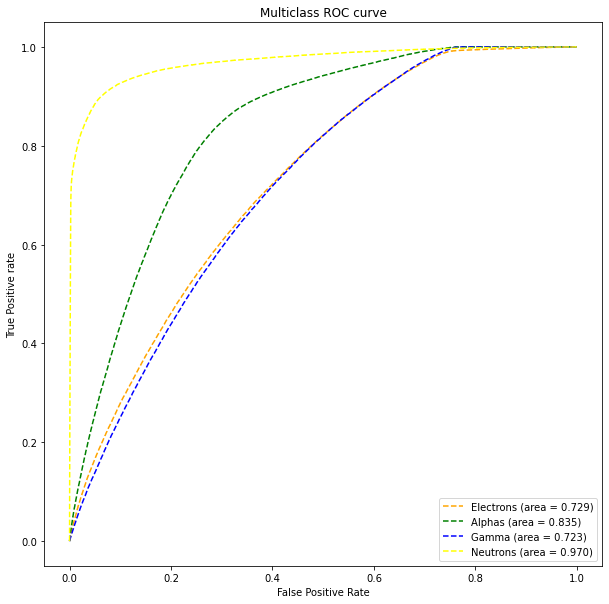

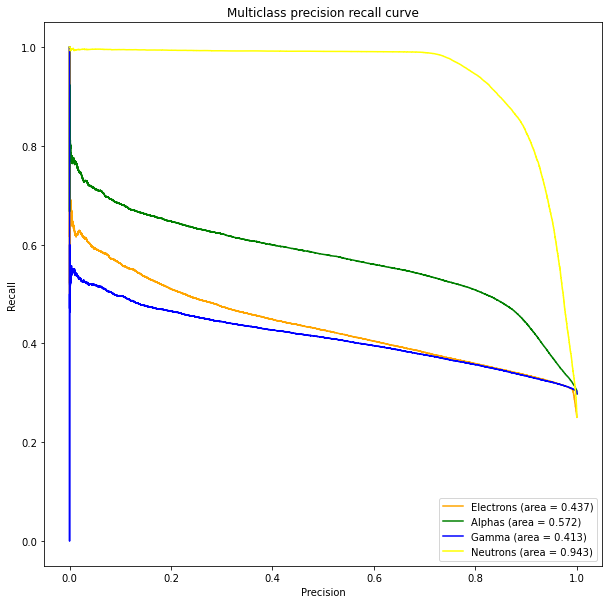

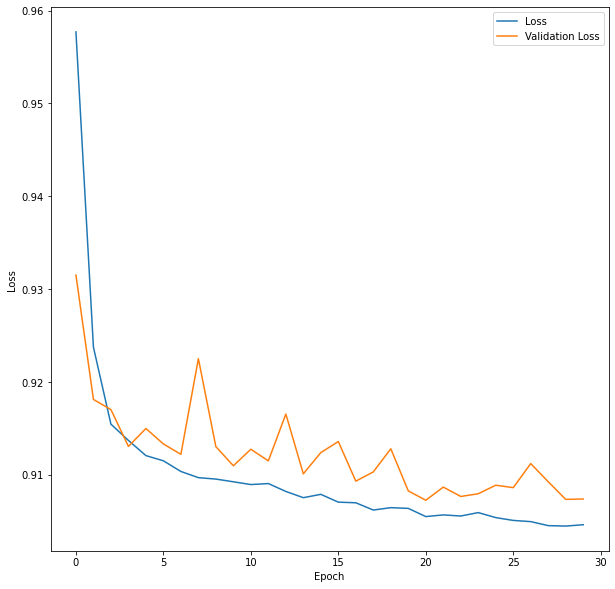

In [27]:
history, labels_test=multiclass(electrons,alphas,neutron_data,rockgamma_data)

proba = model.predict(features_test)

fpr = {}
tpr = {}
thresh ={}
prec={}
recall={}
recall_thresh={}
n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_test[:,i], proba[:,i], pos_label=1)
    prec[i], recall[i],recall_thresh[i] = precision_recall_curve(labels_test[:,i], proba[:,i], pos_label=1)

plt.figure(figsize=(10,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Electrons (area = {:.3f})'.format(auc(fpr[0],tpr[0])))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Alphas (area = {:.3f})'.format(auc(fpr[1],tpr[1])))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Gamma (area = {:.3f})'.format(auc(fpr[2],tpr[2])))
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Neutrons (area = {:.3f})'.format(auc(fpr[3],tpr[3])))
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(recall[0], prec[0],color='orange', label='Electrons (area = {:.3f})'.format(auc(recall[0],prec[0])))
plt.plot(recall[1], prec[1],color='green', label='Alphas (area = {:.3f})'.format(auc(recall[1],prec[1])))
plt.plot(recall[2], prec[2],color='blue', label='Gamma (area = {:.3f})'.format(auc(recall[2],prec[2])))
plt.plot(recall[3], prec[3],color='yellow', label='Neutrons (area = {:.3f})'.format(auc(recall[3],prec[3])))
plt.title('Multiclass precision recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

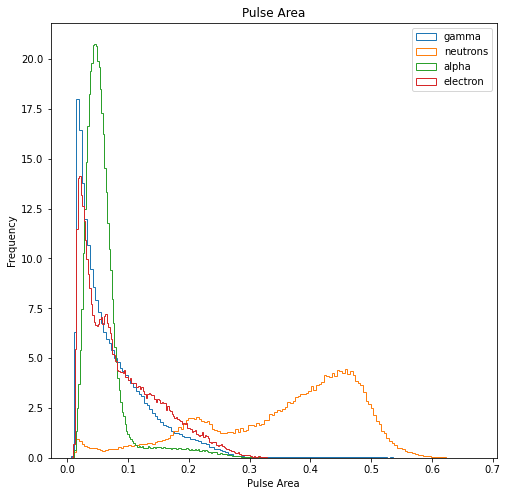

['electron' 'electron' 'electron' ... 'neutron' 'neutron' 'neutron']


In [ ]:
#metrics_bi212_po212,roc_metrics_bi212_po212,pr_metrics_bi212_po212,history_bi212_po212,probs_bi212_po212=binary_run(Data_withtag,"bi212-po212","bi212","po212")
#metrics_neutrons_na22,roc_metrics_neutrons_na22,pr_metrics_neutrons_na22,history_neutrons_na22,proba_neutrons_na22=binary_run(Data_withtag,"neutrons-na22","neutron","na22")
#metrics_bi212_neutrons,roc_metrics_bi212_neutrons,pr_metrics_bi212_neutrons,history_bi212_neutrons,proba_bi212_neutrons=binary_run(Data_withtag,"bi212-neutrons","bi212","neutron")
#metrics_po212_na22,roc_metrics_po212_na22,pr_metrics_po212_na22,history_po212_na22,probs_po212_na22=binary_run(Data_withtag,"po212_na22","po212","na22")

#NN_metrics=(pd.concat([metrics_bi212_po212,metrics_neutrons_na22,metrics_bi212_neutrons,metrics_po212_na22])).set_index('sample')

decay_type=pd.concat([electrons,alphas,neutron_data,rockgamma_data])
chains=pd.concat([Th232_chain,U238_chain])

#metrics_electron_alpha,roc_metrics_electron_alpha,pr_metrics_electron_alpha,history_electron_alpha,proba_electron_alpha=binary_run(decay_type,"electrons vs alphas","electron","alpha")
#metrics_gamma_neutron,roc_metrics_gamma_neutron,pr_metrics_gamma_neutron,history_gamma_neutron,proba_gamma_neutron=binary_run(decay_type,"rockgamma vs neutrons","RockGamma","neutron")
#metrics_gamma_electron,roc_metrics_gamma_electron,pr_metrics_gamma_electron,history_gamma_electron,proba_gamma_electron=binary_run(decay_type,"rockgamma vs electons","RockGamma","electron")
#metrics_electron_neutron,roc_metrics_electron_neutron,pr_metrics_electron_neutron,history_electron_neutron,proba_electron_neutron=binary_run(decay_type,"electron vs neutrons","electron","neutron")
#metrics_chains,roc_metrics_chains,pr_metrics_chains,history_chains,proba_chains=binary_run(chains,"electron vs neutrons","U238","Th232")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(roc_metrics_electron_alpha['FPR'], roc_metrics_electron_alpha['TPR'], label='Electrons vs Alpha (area = {:.3f})'.format(roc_metrics_electron_alpha['auc-roc'].max()))
plt.plot(roc_metrics_gamma_neutron['FPR'], roc_metrics_gamma_neutron['TPR'], label='Gamma vs Neutrons (area = {:.3f})'.format(roc_metrics_gamma_neutron['auc-roc'].max()))
plt.plot(roc_metrics_gamma_electron['FPR'], roc_metrics_gamma_electron['TPR'], label='Gamma vs Electrons (area = {:.3f})'.format(roc_metrics_gamma_electron['auc-roc'].max()))
plt.plot(roc_metrics_electron_neutron['FPR'], roc_metrics_electron_neutron['TPR'], label='Electrons vs Neutrons (area = {:.3f})'.format(roc_metrics_electron_neutron['auc-roc'].max()))
plt.plot(roc_metrics_chains['FPR'], roc_metrics_chains['TPR'], label='Decay chains (area = {:.3f})'.format(roc_metrics_chains['auc-roc'].max()))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.figure(figsize=(10,10))
#plt.plot(roc_metrics_bi212_po212['FPR'], roc_metrics_bi212_po212['TPR'], label='bi212 vs po212 (area = {:.3f})'.format(roc_metrics_bi212_po212['auc-roc'].max()))
#plt.plot(roc_metrics_neutrons_na22['FPR'], roc_metrics_neutrons_na22['TPR'], label='neutron vs na22 (area = {:.3f})'.format(roc_metrics_neutrons_na22['auc-roc'].max()))
#plt.plot(roc_metrics_bi212_neutrons['FPR'], roc_metrics_bi212_neutrons['TPR'], label='neutron vs bi212 (area = {:.3f})'.format(roc_metrics_bi212_neutrons['auc-roc'].max()))
#plt.plot(roc_metrics_po212_na22['FPR'], roc_metrics_po212_na22['TPR'], label='po212 vs na22 (area = {:.3f})'.format(roc_metrics_po212_na22['auc-roc'].max()))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
#plt.title('ROC curve')
#plt.legend(loc='best')
#plt.show()

plt.figure(figsize=(10,10))
plt.title('Precision recall curve')
plt.plot(pr_metrics_electron_alpha['recall'], pr_metrics_electron_alpha['precision'], label='Electrons vs Alpha (area = {:.3f})'.format(pr_metrics_electron_alpha['auc-pr'].max()))
plt.plot(pr_metrics_gamma_neutron['recall'], pr_metrics_gamma_neutron['precision'], label='Gamma vs Neutrons (area = {:.3f})'.format(pr_metrics_gamma_neutron['auc-pr'].max()))
plt.plot(pr_metrics_gamma_electron['recall'], pr_metrics_gamma_electron['precision'], label='Gamma vs electrons (area = {:.3f})'.format(pr_metrics_gamma_electron['auc-pr'].max()))
plt.plot(pr_metrics_electron_neutron['recall'], pr_metrics_electron_neutron['precision'], label='Electrons vs neutrons (area = {:.3f})'.format(pr_metrics_electron_neutron['auc-pr'].max()))
plt.plot(pr_metrics_chains['recall'], pr_metrics_chains['precision'], label='Decay Chains (area = {:.3f})'.format(pr_metrics_chains['auc-pr'].max()))
#plt.plot(pr_metrics_bi212_po212['recall'], pr_metrics_bi212_po212['precision'], label='bi212 vs po212 (area = {:.3f})'.format(pr_metrics_bi212_po212['auc-pr'].max()))
#plt.plot(pr_metrics_neutrons_na22['recall'], pr_metrics_neutrons_na22['precision'], label='neutron vs na22 (area = {:.3f})'.format(pr_metrics_neutrons_na22['auc-pr'].max()))
#plt.plot(pr_metrics_bi212_neutrons['recall'], pr_metrics_bi212_neutrons['precision'], label='neutron vs bi212 (area = {:.3f})'.format(pr_metrics_bi212_neutrons['auc-pr'].max()))
#plt.plot(pr_metrics_po212_na22['recall'], pr_metrics_po212_na22['precision'], label='po212 vs na22 (area = {:.3f})'.format(pr_metrics_po212_na22['auc-pr'].max()))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
plt.figure(figsize=(10,10))
plt.plot(history_electron_alpha.history['precision'],label='Electrons-Alphas')
plt.plot(history_electron_alpha.history['val_precision'],label='Electrons-Alphas')
plt.plot(history_gamma_neutron.history['precision'],label='Gamma-Neutrons')
plt.plot(history_gamma_neutron.history['val_precision'],label='Gamma-Neutrons')
plt.plot(history_gamma_electron.history['precision'],label='Electrons-Gamma')
plt.plot(history_gamma_electron.history['val_precision'],label='Electrons-Gamma')
plt.plot(history_electron_neutron.history['precision'],label='Electrons-Neutrons')
plt.plot(history_electron_neutron.history['val_precision'],label='Electrons-Neutrons')
plt.plot(history_chains.history['precision'],label='Decay Chains')
plt.plot(history_chains.history['val_precision'],label='Decay Chains')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(10,10))
plt.hist(proba_electron_alpha,bins=150,stacked=True,density=True)
plt.title("electron vs alpha")
plt.xlabel('Probailiity of alpha')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_gamma_neutron,bins=150,stacked=True,density=True)
plt.title("gamma vs neutron")
plt.xlabel('probability of neutron')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_gamma_electron,bins=150,stacked=True,density=True)
plt.title("electron vs gamma")
plt.xlabel('Probability of electron')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_electron_neutron,bins=150,stacked=True,density=True)
plt.title("electron vs neutron")
plt.xlabel('Probability of neutron')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_chains,bins=150,stacked=True,density=True)
plt.title("U238 vs Th232")
plt.xlabel('Probability of Th232')
plt.show()

plt.figure(figsize=(10,10))
plt.hist(probs_bi212_po212,bins=150,stacked=True,density=True)
plt.title("bi212 vs po212")
plt.xlabel('Probailiity of po212')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_neutrons_na22,bins=150,stacked=True,density=True)
plt.title("neutron vs na22")
plt.xlabel('probability of na22')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(proba_bi212_neutrons,bins=150,stacked=True,density=True)
plt.title("neutron vs bi212")
plt.xlabel('Probability of bi212')
plt.show()
plt.figure(figsize=(10,10))
plt.hist(probs_po212_na22,bins=150,stacked=True,density=True)
plt.title("po212 vs na22")
plt.xlabel('Probability of na22')
plt.show()



In [ ]:
electron_data=info[0]
alpha_data=info[1]
neutron_data=info[2]
gamma_data=info[3]

electron_max=electron_data[electron_data['F1 score'] == electron_data['F1 score'].max()]
electron_metrics=electron_data[electron_data['minval']== electron_max['minval'].max()]
auc_electron=auc(1-electron_metrics['specificity'], electron_metrics['recall'])

alpha_max=alpha_data[alpha_data['F1 score'] == alpha_data['F1 score'].max()]
alpha_metrics=alpha_data[alpha_data['minval']== alpha_max['minval'].max()]
auc_alpha=auc(1-alpha_metrics['specificity'], alpha_metrics['recall'])


neutron_max=neutron_data[neutron_data['F1 score'] == neutron_data['F1 score'].max()]
neutron_metrics=neutron_data[neutron_data['minval']== neutron_max['minval'].max()]
auc_neutron=auc(1-neutron_metrics['specificity'], neutron_metrics['recall'])


gamma_max=gamma_data[gamma_data['F1 score'] == gamma_data['F1 score'].max()]
gamma_metrics=gamma_data[gamma_data['minval']== gamma_max['minval'].max()]
auc_gamma=auc(1-gamma_metrics['specificity'], gamma_metrics['recall'])



plt.figure(figsize=(10,10))
plt.plot(1-electron_metrics['specificity'],electron_metrics['recall'],label='Best electron(area = {:.3f})'.format(auc_electron))
plt.plot(1-alpha_metrics['specificity'],alpha_metrics['recall'],label='Best alpha(area = {:.3f})'.format(auc_alpha))
plt.plot(1-neutron_metrics['specificity'],neutron_metrics['recall'],label='Best neutrons(area = {:.3f})'.format(auc_neutron))
plt.plot(1-gamma_metrics['specificity'],gamma_metrics['recall'],label='Best gamma(area = {:.3f})'.format(auc_gamma))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()




In [ ]:
plt.figure(figsize=(10,10))
pr_metrics_po212_na22=pr_metrics_po212_na22.dropna()
pr_metrics_bi212_po212=pr_metrics_bi212_po212.dropna()
pr_metrics_neutron_na22=pr_metrics_neutrons_na22.dropna()
pr_metrics_neutron_bi212=pr_metrics_bi212_neutrons.dropna()

plt.plot(pr_metrics_po212_na22['thresholds'],pr_metrics_po212_na22['precision'], label='po212 vs na22 precision')
plt.plot(pr_metrics_bi212_po212['thresholds'],pr_metrics_bi212_po212['precision'], label='po212 vs bi212 precision')
plt.plot(pr_metrics_neutron_na22['thresholds'],pr_metrics_neutron_na22['precision'], label='neutron vs na22 precision')
plt.plot(pr_metrics_neutron_bi212['thresholds'],pr_metrics_neutron_bi212['precision'], label='neutron vs na22 precision')

plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Varying threshold')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(pr_metrics_po212_na22['thresholds'],pr_metrics_po212_na22['recall'], label= 'po212 vs na22 recall')
plt.plot(pr_metrics_bi212_po212['thresholds'],pr_metrics_bi212_po212['recall'], label= 'po212 vs bi212 recall')
plt.plot(pr_metrics_neutron_na22['thresholds'],pr_metrics_neutron_na22['recall'], label= 'neutron vs na22 recall')
plt.plot(pr_metrics_neutron_bi212['thresholds'],pr_metrics_neutron_bi212['recall'], label= 'neutron vs na22 recall')

plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Varying threshold')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(10,10))
plt.plot(roc_metrics_po212_na22['thresholds'],(2*pr_metrics_po212_na22['recall']*pr_metrics_po212_na22['precision'])/(pr_metrics_po212_na22['recall']+pr_metrics_po212_na22['precision'][:-1]), label= 'po212 vs na22 F1 score')
plt.plot(roc_metrics_bi212_po212['thresholds'],(2*pr_metrics_bi212_po212['recall']*pr_metrics_bi212_po212['precision'])/(pr_metrics_bi212_po212['recall']+pr_metrics_bi212_po212['precision'][:-1]), label= 'po212 vs bi212 F1 score')
plt.plot(roc_metrics_neutron_na22['thresholds'],(2*pr_metrics_neutron_na22['recall']*pr_metrics_neutron_na22['precision'])/(pr_metrics_neutron_na22['recall']+pr_metrics_neutron_na22['precision'][:-1]), label= 'neutron vs na22 F1 score')
plt.plot(roc_metrics_neutron_bi212['thresholds'],(2*pr_metrics_neutron_bi212['recall']*pr_metrics_neutron_bi212['precision'])/(pr_metrics_neutron_bi212['recall']+pr_metrics_neutron_bi212['precision'][:-1]), label= 'neutron vs na22 F1 score')

plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('Varying threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
labels=['Pulse Area', 'Coincidence', 'Peak Time', 'Peak Amp', 'Pulse Length', 'Area/time']
accuracy=[0.915,0.842,0.859,0.822,0.845,0.889]
recall=[0.935,0.476,0.777,0.376,0.762,0.738]
precision=[0.778,0.844,0.705,0.851,0.687,0.812]
F1=[0.858,0.609,0.739,0.521,0.722,0.774]
specificity=[0.907,0.969,0.887,0.977,0.880,0.941]


width = 0.35 

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
X = np.arange(6)
ax.bar(X-0.25, recall, width = 0.25,label="Recall")
ax.bar(X , precision, width = 0.25,label="Precision")
ax.bar(X + 0.25, F1, width = 0.25,label="F1")
ticks=[0,1,2,3,4,5]
ax.set_xticks(ticks, labels)
ax.set_ylabel('Metrics')
ax.set_title('Metrics for different features')



plt.legend(loc='best')
plt.show()

In [ ]:
print(history_bi212_po212.history.keys())

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history_bi212_po212.history['val_accuracy'],label='Bi212-Po212')
plt.plot(history_neutrons_na22.history['val_accuracy'],label='neutron-na22')
plt.plot(history_bi212_neutrons.history['val_accuracy'],label='Bi212-neutron')
plt.plot(history_po212_na22.history['val_accuracy'],label='Po212-Na22')
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend( loc='best')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history_bi212_po212.history['val_loss'],label='Bi212-Po212')
plt.plot(history_neutrons_na22.history['val_loss'],label='neutron-na22')
plt.plot(history_bi212_neutrons.history['val_loss'],label='Bi212-neutron')
plt.plot(history_po212_na22.history['val_loss'],label='Po212-Na22')
plt.title('validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='best')
plt.show()


In [ ]:
print(neutron_data['tag'])